**Imports**

In [1]:
import tensorflow.keras as keras
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.optimizers import SGD
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers import Activation
from keras.layers.convolutional import Conv2D, Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from google.colab import drive, files 
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


**Functions**

In [0]:
def process_images(df):
    processed = []
    for row in df.values:
        kernel = Gaussian2DKernel(x_stddev=1.5, x_size = 5, y_size = 5)
        img = np.reshape(row, (32, 32))
        fixed_image = interpolate_replace_nans(img, kernel, boundary='extend')
        
        processed.append(fixed_image.flatten())

    df = pd.DataFrame(processed)
    return df

In [0]:
def remove_outliers(data, threshold = 3):
    means = data.mean()
    stds = data.std()
    
    zscores = (data - means) / stds
    zscores = zscores.abs()
    
    valid_data = data[zscores <= threshold]
    
    return valid_data

def remove_outliers_modzscore(data, threshold = 3.5):
    
    median = data.median()
    
    median_absD = data - median
    median_absD = median_absD.abs()
    median_absD = median_absD.median()
    
    mod_zscore = (0.6475 * (data - median)) / median_absD
    mod_zScore = mod_zscore.abs()
    
    valid_data = data[mod_zscore <= threshold]
    
    return valid_data

In [0]:
def process_data(data, outlier_flag = True):
    cols = data.columns.tolist()[368:1392]
    label = None
    df = pd.DataFrame(data[cols])  
    
    df = process_images(df)
    
    if outlier_flag == True:
        
        l0_df = df[data['label'] == 0]
        l0_df = remove_outliers_modzscore(l0_df, 2.5)
        l0_df = l0_df.dropna()
        l0_df['label'] = 0
        
        l1_df = df[data['label'] == 1]
        l1_df = remove_outliers_modzscore(l1_df, 2.5)
        l1_df = l1_df.dropna()
        l1_df['label'] = 1
        
        l2_df = df[data['label'] == 2]
        l2_df = remove_outliers_modzscore(l2_df, 2.5)
        l2_df = l2_df.dropna()
        l2_df['label'] = 2
        
        l3_df = df[data['label'] == 3]
        l3_df = remove_outliers_modzscore(l3_df, 2.5)
        l3_df = l3_df.dropna()
        l3_df['label'] = 3
        
        l4_df = df[data['label'] == 4]
        l4_df = remove_outliers_modzscore(l4_df, 2.5)
        l4_df = l4_df.dropna()
        l4_df['label'] = 4
        
        l5_df = df[data['label'] == 5]
        l5_df = remove_outliers_modzscore(l5_df, 2.5)
        l5_df = l5_df.dropna()
        l5_df['label'] = 5
        
        l6_df = df[data['label'] == 6]
        l6_df = remove_outliers_modzscore(l6_df, 2.5)
        l6_df = l6_df.dropna()
        l6_df['label'] = 6
        
        l7_df = df[data['label'] == 7]
        l7_df = remove_outliers_modzscore(l7_df, 2.5)
        l7_df = l7_df.dropna()
        l7_df['label'] = 7
        
        l8_df = df[data['label'] == 8]
        l8_df = remove_outliers_modzscore(l8_df, 2.5)
        l8_df = l8_df.dropna()
        l8_df['label'] = 8
        
        l9_df = df[data['label'] == 9]
        l9_df = remove_outliers_modzscore(l9_df, 2.5)
        l9_df = l9_df.dropna()
        l9_df['label'] = 9
        
        label_df = pd.concat([l0_df, l1_df, l2_df, l3_df, l4_df, l5_df, l6_df, l7_df, l8_df, l9_df])
        
        df = label_df.sample(frac = 1).reset_index(drop = True)
        
        label = df['label']
        del df['label']
    
    result = tf.keras.utils.normalize(df.values, axis = 1, order = 2)
    
    return result, label

In [0]:
def write_output(predictions):
    output = []
    index = 0
    for pred in predictions:
        output.append([index, int(pred)])
        index += 1

    df = pd.DataFrame(output, columns = ['id', 'label'])
    df.to_csv('test_predictions.csv', index=False, encoding='utf-8')
    files.download('test_predictions.csv')

In [0]:
def resize_data(data):
    data = np.reshape(data, (len(data), 32, 32))
    processed = []

    for row in data:
        d = np.repeat(row, 3, axis = 1)
        k = np.reshape(d, (1024, 3))
        j = np.reshape(d, (32, 32, 3))
        processed.append(j)

    return np.array(processed)

**Connect Drive to Colab**

In [7]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Reading Data**

In [0]:
train_data = pd.read_csv("/content/drive/My Drive/DM Data/Train.csv")
test_data = pd.read_csv("/content/drive/My Drive/DM Data/Test.csv")

**Testing out convolution on a single image**

Text(0.5, 1.0, 'Fixed interpolation')

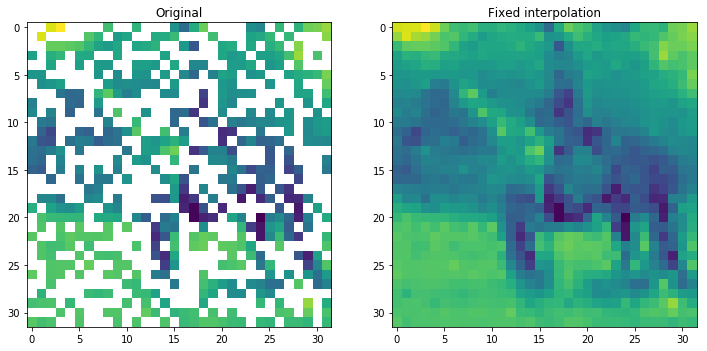

In [9]:
cols = train_data.columns.tolist()[368:1392]

df = pd.DataFrame(train_data[cols])  

kernel = Gaussian2DKernel(x_stddev=1)
img = np.reshape(df.values[0], (32, 32))

fixed_image = interpolate_replace_nans(img, kernel, boundary='extend')

plt.figure(1, figsize=(12, 6)).clf()
plt.close(2)

ax1 = plt.subplot(1, 2, 1)
im = ax1.imshow(img)
ax1.set_title("Original")

ax2 = plt.subplot(1, 2, 2)
im = ax2.imshow(fixed_image)
ax2.set_title("Fixed interpolation")

**Processing Data**

In [0]:
train, label = process_data(train_data)
test, l = process_data(test_data, False)

**Reshaping Data into DataBlob**

In [11]:
train_res = resize_data(train)
test_res = resize_data(test)
train_res.shape, test_res.shape

((40829, 32, 32, 3), (9700, 32, 32, 3))

**Creating our Neural Network**

In [12]:
CNNModel = Sequential()
CNNModel.add(Conv2D(32, (3, 3), padding = "same", input_shape = (32, 32, 3)))
CNNModel.add(Activation("relu"))
CNNModel.add(Conv2D(32, (3, 3)))
CNNModel.add(Activation("relu"))
CNNModel.add(MaxPooling2D(pool_size = (2, 2)))
CNNModel.add(Dropout(0.25))

CNNModel.add(Conv2D(64, (3, 3), padding = "same"))
CNNModel.add(Activation("relu"))
CNNModel.add(Conv2D(64, (3, 3)))
CNNModel.add(Activation("relu"))
CNNModel.add(MaxPooling2D(pool_size = (2, 2)))
CNNModel.add(Dropout(0.25))

CNNModel.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
CNNModel.add(Dropout(0.2))
CNNModel.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
CNNModel.add(MaxPooling2D(pool_size=(2, 2)))
CNNModel.add(Dropout(0.2))

CNNModel.add(Flatten())
CNNModel.add(Dense(1024))
CNNModel.add(Activation("relu"))
CNNModel.add(Dropout(0.5))
CNNModel.add(Dense(10))
CNNModel.add(Activation("softmax"))

CNNModel.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


**Training the Model**

In [13]:
CNNModel.fit(train_res, label, epochs=70, batch_size = 200, shuffle = True)

Instructions for updating:
Use tf.cast instead.
Epoch 1/70
40829/40829 [==============================] - 12s 299us/step - loss: 2.1285 - acc: 0.2033
Epoch 2/70
40829/40829 [==============================] - 10s 249us/step - loss: 1.8437 - acc: 0.3363
Epoch 3/70
40829/40829 [==============================] - 10s 248us/step - loss: 1.7126 - acc: 0.3877
Epoch 4/70
40829/40829 [==============================] - 10s 248us/step - loss: 1.5987 - acc: 0.4354
Epoch 5/70
40829/40829 [==============================] - 10s 248us/step - loss: 1.5180 - acc: 0.4671
Epoch 6/70
40829/40829 [==============================] - 10s 252us/step - loss: 1.4457 - acc: 0.4971
Epoch 7/70
40829/40829 [==============================] - 10s 255us/step - loss: 1.4003 - acc: 0.5186
Epoch 8/70
40829/40829 [==============================] - 10s 252us/step - loss: 1.3553 - acc: 0.5331
Epoch 9/70
40829/40829 [==============================] - 10s 251us/step - loss: 1.3072 - acc: 0.5559
Epoch 10/70
40829/40829 [=========

**Saving trained model to file**

**Generating test predictions**

In [14]:
predictions = CNNModel.predict(test_res)
predictions = np.argmax(predictions, axis = 1)
predictions

array([4, 0, 1, ..., 8, 7, 3])

**Writing predictions to file**

In [0]:
write_output(predictions)